# Dot Plots
simulated and measured receptions

In [1]:
import xarray as xr
import bighorn
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import colors as mcolors
from scipy import signal
from tqdm import tqdm
import multiprocessing as mp
import kaooi
from matplotlib import dates as mdates
import matplotlib.lines as lines
from dask.distributed import Client
import pandas as pd
import envy
import geopy.distance as geo
from matplotlib import gridspec
from kaooi.coordinates import coords, depths
import hvplot.xarray 
from dask_jobqueue import SLURMCluster
#hydrophones.remove('LJ03A')
#hydrophones.remove('HYSB1')
from scipy.interpolate import interp1d
from dask_jobqueue import SLURMCluster
from datetime import datetime
from dotenv import load_dotenv
import os

# load .env file
env_path = '../.env'
_ = load_dotenv(env_path)

%config InlineBackend.figure_format = 'retina'

/gscratch/coenv/jhrag/miniconda/envs/kb/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Load Data

### load measured receptions

In [2]:
hydrophones_plot = ['AXCC1','AXBA1','AXEC2','HYS14','LJ01C','PC01A','PC03A']

In [3]:
# open computed arrivals
fn = f'{os.environ["data_directory"]}analysis/bb_stack.nc'
bb_stack = xr.open_dataset(fn)

fn = f'{os.environ["data_directory"]}analysis/lf_stack.nc'
lf_stack = xr.open_dataset(fn)

peaks = {}

noise_bounds = {
    'AXCC1':(17,27),
    'AXEC2':(17,27),
    'AXBA1':(17,27),
    'HYS14':(17,27),
    'LJ01C':(17,27),
    'PC01A':(5,15),
    'PC03A':(17,27),
}

for node in hydrophones_plot:
    if node in ['AXCC1','AXBA1','AXEC2','HYS14','HYSB1']:
        peaks[node] = kaooi.estimate_peaks_array(np.abs(lf_stack[node]), noise_slice = noise_bounds[node], flatten=True, snr_threshold=5, timestamp='date')
    else:
        peaks[node] = kaooi.estimate_peaks_array(np.abs(bb_stack[node]), noise_slice = noise_bounds[node], flatten=True, snr_threshold=5, timestamp='date')

### load PE climate arrivals

In [4]:
peaks_pe = {}
peak_heights = {}

Gts = {}
peaks_flatten_b = {}
peak_heights_flatten_b = {}
months_flatten_b = {}
for node in tqdm(hydrophones_plot):
    peaks_pe[node] = {}
    peak_heights[node] = {}
    Gts[node] = []
    
    for month in range(12):
        fn = f'{os.environ["data_directory"]}monthly_arrivals/climate_Gtz_{node}_{month+1:02}'
        if node == 'PC01A':
            fn = f'{os.environ["data_directory"]}monthly_arrivals/climate_Gtz_LJ01A_{month+1:02}'
        if node == 'PC03A':
            fn = f'{os.environ["data_directory"]}monthly_arrivals/climate_Gtz_AXBA1_{month+1:02}'

        Gf = xr.open_dataarray(f'{fn}_real.nc') + 1j*xr.open_dataarray(f'{fn}_imag.nc')
        Gtz = bighorn.convert_to_time(Gf, Fs=300, To=10, bandwidth=(37.5, 112.5))
        Gt = Gtz.sel({'depth':depths[node]}, method='nearest')
        
        # peak finding algorithm
        peak_locs_single, peak_props_single = signal.find_peaks(np.abs(Gt.values), height=0)
    
        peaks_pe[node][month+1] = Gt.time[peak_locs_single].values
        peak_heights[node][month+1] = peak_props_single['peak_heights']
    
        Gts[node].append(Gt)
    peaks_flatten_b[node] = []
    peak_heights_flatten_b[node] = []
    months_flatten_b[node] = []
    for k in range(1,13):
        peaks_flatten_b[node] += list(peaks_pe[node][k])*7
        peak_heights_flatten_b[node] += list(peak_heights[node][k])*7
        mmonth,_ = np.meshgrid(np.linspace(k,k+1,len(peaks_pe[node][k])), np.arange(7))
        months_flatten_b[node] += list(mmonth.T.flatten())
        
    peaks_flatten_b[node] = np.array(peaks_flatten_b[node])
    peak_heights_flatten_b[node] = np.array(peak_heights_flatten_b[node])
    months_flatten_b[node] = np.array(months_flatten_b[node])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


### Load PE climate arrivals + internal waves

In [5]:
peaks_pe_iw = {}
peak_heights_iw = {}

Gts = {}
peaks_flatten_iw = {}
peak_heights_flatten_iw = {}
months_flatten_iw = {}
for node in tqdm(hydrophones_plot):
    peaks_pe_iw[node] = {}
    peak_heights_iw[node] = {}
    Gts[node] = []
    for month in range(12):
        fn = f'{os.environ["data_directory"]}monthly_arrivals/iw_climate_Gtz_{node}_{month+1:02}_iw'
        if node == 'PC01A':
            fn = f'{os.environ["data_directory"]}monthly_arrivals/iw_climate_Gtz_LJ01A_{month+1:02}_iw'
        if node == 'PC03A':
            fn = f'{os.environ["data_directory"]}monthly_arrivals/iw_climate_Gtz_AXBA1_{month+1:02}_iw'
        Gf = xr.open_dataarray(f'{fn}_real.nc') + 1j*xr.open_dataarray(f'{fn}_imag.nc')
        Gtz = bighorn.convert_to_time(Gf, Fs=300, To=10, bandwidth=(37.5, 112.5))
        Gt = Gtz.sel({'depth':depths[node]}, method='nearest')
        
        # peak finding algorithm
        peak_locs_single, peak_props_single = signal.find_peaks(np.abs(Gt.values), height=0)
    
        peaks_pe_iw[node][month+1] = Gt.time[peak_locs_single].values
        peak_heights_iw[node][month+1] = peak_props_single['peak_heights']
    
        Gts[node].append(Gt)
    peaks_flatten_iw[node] = []
    peak_heights_flatten_iw[node] = []
    months_flatten_iw[node] = []
    for k in range(1,13):
        peaks_flatten_iw[node] += list(peaks_pe_iw[node][k])*7
        peak_heights_flatten_iw[node] += list(peak_heights_iw[node][k])*7
        mmonth,_ = np.meshgrid(np.linspace(k,k+1,len(peaks_pe_iw[node][k])), np.arange(7))
        months_flatten_iw[node] += list(mmonth.T.flatten())
        
    peaks_flatten_iw[node] = np.array(peaks_flatten_iw[node])
    peak_heights_flatten_iw[node] = np.array(peak_heights_flatten_iw[node])
    months_flatten_iw[node] = np.array(months_flatten_iw[node])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


## Create Figures

### Low Frequency Hydrophones

In [6]:
s_rec = {}

for node in hydrophones_plot:
    if node in ['AXCC1','AXEC2']:
        s_rec[node] = (peaks[node]['snrs'] - 7.5)/4
        s_rec[node][s_rec[node]<0]=0
    elif node == 'AXBA1':
        s_rec[node] = (peaks[node]['snrs'] - 8)/1
        s_rec[node][s_rec[node]<0]=0
    elif node == 'LJ01C':
        s_rec[node] = (peaks[node]['snrs'] - 8.5)/8
        s_rec[node][s_rec[node]<0]=0
    elif node in ['PC01A', 'PC03A']:
        s_rec[node] = (peaks[node]['snrs'] - 7.5)/4
        s_rec[node][s_rec[node]<0]=0
    elif node == 'HYS14':
        s_rec[node] = (peaks[node]['snrs'] - 7.5)/4
        s_rec[node][s_rec[node]<0]=0

s_peb = {}
for node in hydrophones_plot:
    if node in ['AXCC1','AXEC2']:
        s_peb[node] = (20*np.log10(peak_heights_flatten_b[node]) - 20*np.log10(2e-8)) / 6 # was 10e-8
        s_peb[node][s_peb[node]<0] = 0
    elif node == 'AXBA1':
        s_peb[node] = (20*np.log10(peak_heights_flatten_b[node]) - 20*np.log10(2e-8)) / 2
        s_peb[node][s_peb[node]<0] = 0
    elif node == 'LJ01C':
        s_peb[node] = (20*np.log10(peak_heights_flatten_b[node]) - 20*np.log10(2e-8)) / 10
        s_peb[node][s_peb[node]<0] = 0
    elif node in ['PC01A','PC03A']:
        s_peb[node] = (20*np.log10(peak_heights_flatten_b[node]) - 20*np.log10(2e-8)) / 6
        s_peb[node][s_peb[node]<0] = 0
    elif node == 'HYS14':
        s_peb[node] = (20*np.log10(peak_heights_flatten_b[node]) - 20*np.log10(2e-8)) / 6
        s_peb[node][s_peb[node]<0] = 0

s_peiw = {}
for node in hydrophones_plot:
    if node in ['AXCC1','AXEC2']:
        s_peiw[node] = (20*np.log10(peak_heights_flatten_iw[node]) - 20*np.log10(2e-8)) / 6 # was 10e-8
        s_peiw[node][s_peiw[node]<0] = 0
    elif node == 'AXBA1':
        s_peiw[node] = (20*np.log10(peak_heights_flatten_iw[node]) - 20*np.log10(2e-8)) / 2
        s_peiw[node][s_peiw[node]<0] = 0
    elif node == 'LJ01C':
        s_peiw[node] = (20*np.log10(peak_heights_flatten_iw[node]) - 20*np.log10(2e-8)) / 10
        s_peiw[node][s_peiw[node]<0] = 0
    elif node in ['PC01A','PC03A']:
        s_peiw[node] = (20*np.log10(peak_heights_flatten_iw[node]) - 20*np.log10(2e-8)) / 6
        s_peiw[node][s_peiw[node]<0] = 0
    elif node == 'HYS14':
        s_peiw[node] = (20*np.log10(peak_heights_flatten_iw[node]) - 20*np.log10(2e-8)) / 6
        s_peiw[node][s_peiw[node]<0] = 0

vlims_obs = {
    'AXCC1':(16,6),
    'AXEC2':(16,6),
    'AXBA1':(16,6),
    'LJ01C':(16,6),
    'PC01A':(16,6),
    'PC03A':(16,6),
    'HYS14':(16,6),
}

vlims_pe = {
    'AXCC1':(-125,-155),
    'AXEC2':(-125,-155),
    'AXBA1':(-125,-155),
    'LJ01C':(-125,-155),
    'PC01A':(-125,-155),
    'PC03A':(-125,-155),
    'HYS14':(-125,-155),
}

vlims_pe = {
    'AXCC1':(-135,-145),
    'AXEC2':(-135,-145),
    'AXBA1':(-135,-145),
    'LJ01C':(-135,-145),
    'PC01A':(-135,-145),
    'PC03A':(-135,-145),
    'HYS14':(-135,-145),
}

vlims_pe_cb = {
    'AXCC1':(-125,-155),
    'AXEC2':(-125,-155),
    'AXBA1':(-125,-155),
    'LJ01C':(-125,-155),
    'PC01A':(-125,-155),
    'PC03A':(-125,-155),
    'HYS14':(-125,-155),
}

ylims = {
    'AXBA1':[6,13],
    'AXCC1':[1,7],
    'AXEC2':[2,8],
    'HYS14':[0, 27.28],
    'LJ01A':[0, 27.28],
    'LJ01C':[9.5,14.5],
    'LJ01D':[0, 27.28],
    'PC01A':[20.5,26.5],
    'PC03A':[7,13],
    'HYSB1':[0, 27.28],
    'LJ03A':[0,27.28]
}

mls_integer = {
    'AXCC1':92,
    'AXEC2':92,
    'AXBA1':92,
    'LJ01C':98,
    'PC01A':97,
    'PC03A':92,
    'HYS14':98
}

fs_integer = {
    'AXCC1':252,
    'AXEC2':252,
    'AXBA1':252,
    'LJ01C':268,
    'PC01A':267,
    'PC03A':252,
    'HYS14':268
}

delta_t = {
    'AXCC1':1.33,
    'AXEC2':1.59,
    'AXBA1':1.69,
    'LJ01C':2.24,
    'PC01A':2.41,
    'PC03A':1.45,
}

In [7]:
def construct_row(gs, r_idx):
    '''
    Parameters
    ----------
    gs : gridspec of shape 4,4
    r_idx : index of row
    '''
    
    ## construct skeleton  
    gs_inner = gs[r_idx,:].subgridspec(1,3, wspace=0.02, hspace=0)
    ax_obs = fig.add_subplot(gs_inner[0,0])
    ax_pe1 = fig.add_subplot(gs_inner[0,1])
    ax_pe2 = fig.add_subplot(gs_inner[0,2])
    
    axes_r = [ax_obs, ax_pe1, ax_pe2]

    return axes_r

(-135, -145)


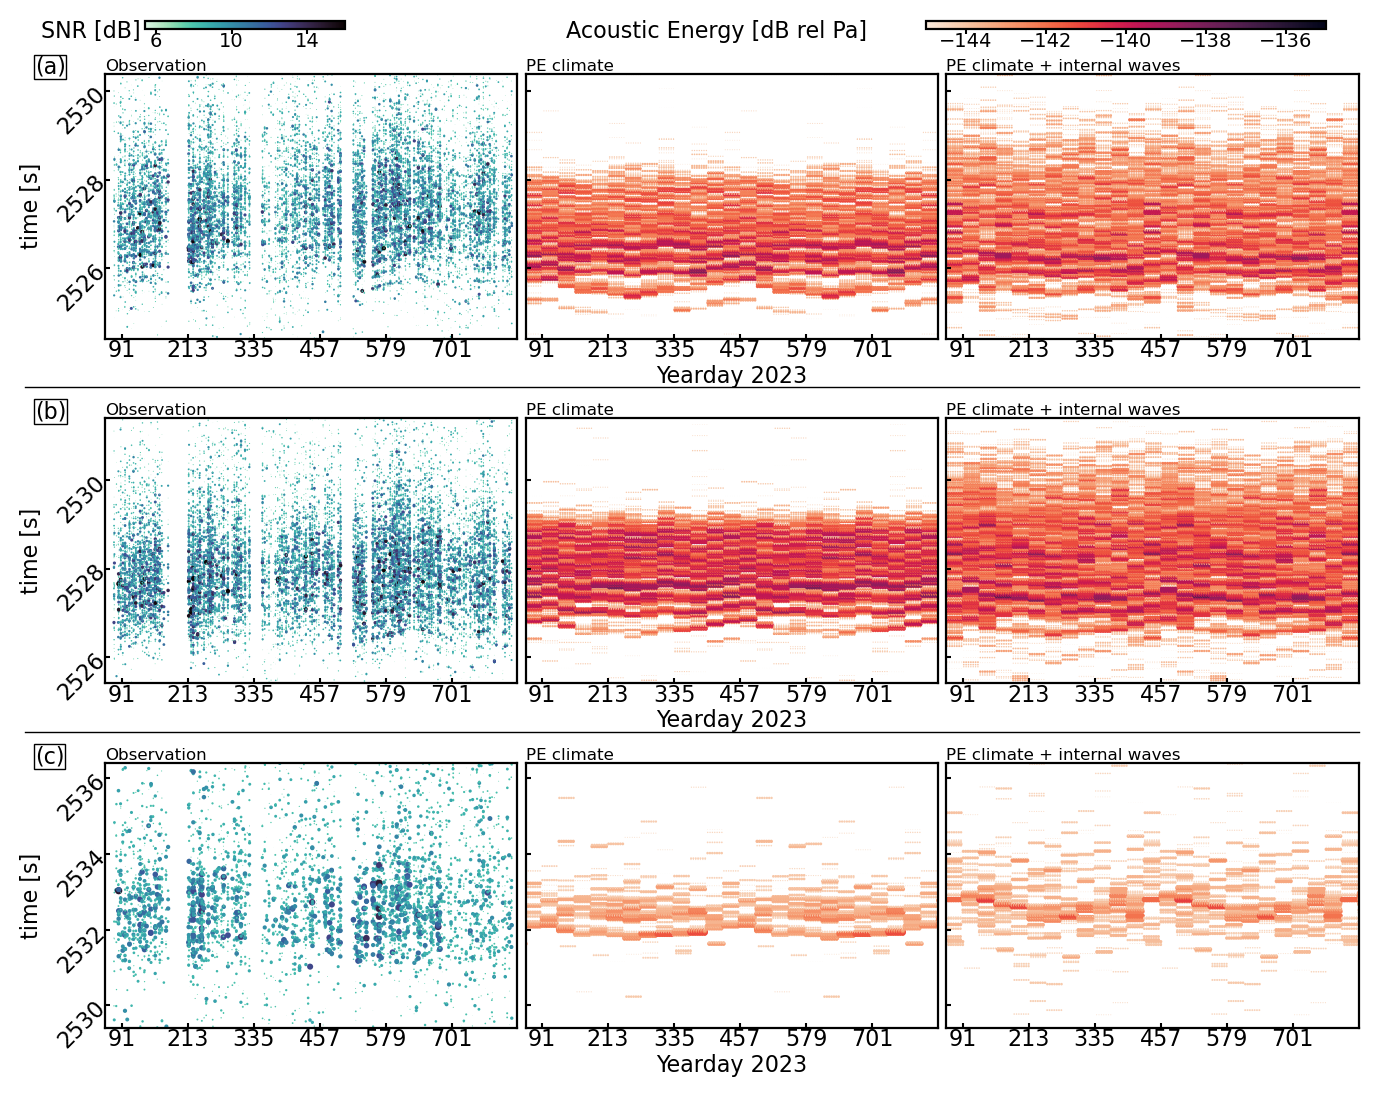

In [10]:
# Full Figure LF
node_plot = ['AXBA1', 'AXCC1','AXEC2']

plt.rcParams.update({'font.size':8})

fig = plt.figure(figsize=(6.67,5.25))

gs = gridspec.GridSpec(3,1)

axes_r1 = construct_row(gs, 0)
axes_r2 = construct_row(gs, 1)
axes_r3 = construct_row(gs, 2)

axes = [axes_r1, axes_r2, axes_r3]

# make ticks be inside plot
for axes_r in axes:
    for ax in axes_r:
        ax.tick_params(axis='y', direction='in', length=1.8, width=0.75)
        ax.tick_params(axis='x', direction='in', length=1.8, width=0.75)

# remove tick_labels:
for axes_r in axes:
    for ax in axes_r[1:]:
        ax.set_yticklabels('')

# add ylabel
for axes_r in axes:
    axes_r[0].set_ylabel('time [s]')

# add letter
letters = ['(a)','(b)','(c)','(d)']
for k, axes_r in enumerate(axes):
    axes_r[0].text(
        -0.17,
        1,
        letters[k],
        transform=axes_r[0].transAxes,
        fontsize=8,
        zorder=100,
        bbox=dict(facecolor='white', edgecolor='k', pad=0.3, linewidth=0.5))
    
# add titles to top row
for k in range(3):
    _ = axes[k][0].set_title('Observation', loc='left', fontsize=6, pad=0)
    _ = axes[k][1].set_title('PE climate', loc='left', fontsize=6, pad=0)
    _ = axes[k][2].set_title('PE climate + internal waves', loc='left', fontsize=6, pad=0)


# Plot observations
for k, node in enumerate(['AXCC1','AXEC2','AXBA1']):
    if node not in node_plot:
        continue
    plt.sca(axes[k][0])
       
    plt.scatter(
        y=peaks[node]['peak_times'] + mls_integer[node]*27.28 + 27.28/2,
        x=peaks[node]['Txs'],
        s=s_rec[node],
        c=peaks[node]['snrs'],
        lw=0,
        cmap='mako_r',
        vmax=vlims_obs[node][0],
        vmin=vlims_obs[node][1],
        rasterized=True
    )
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%J'))
    plt.ylabel('time [s]')
    plt.xlim([pd.Timestamp('2023-03-01'), pd.Timestamp('2025-04-01')])
    plt.xticks([
        pd.Timestamp('2023-04-01'),
        pd.Timestamp('2023-08-01'),
        pd.Timestamp('2023-12-01'),
        pd.Timestamp('2024-04-01'),
        pd.Timestamp('2024-08-01'),
        pd.Timestamp('2024-12-01'),
    ], [91,213,335,457,579, 701])
    
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
    axes[k][0].tick_params(axis='y', pad=-2, labelrotation=45)

# Plot simulated climate arrivals
for k, node in enumerate(['AXCC1','AXEC2','AXBA1','HYS14']):
    if node not in node_plot:
        continue
    plt.sca(axes[k][1])

    plt.scatter(
        x=months_flatten_b[node],
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node],
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+12,
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+12,
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+24,
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+24,
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    _ = plt.xticks([4,8,12,16,20,24], [91,213,335,457,579,701])
    plt.xlim([3,12+12+4]) # march 1 2023 to april 1 2024
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
    plt.xlabel('Yearday 2023', labelpad=1)

# add Climate + IW
for k, node in enumerate(['AXCC1','AXEC2','AXBA1','HYS14']):
    if node not in node_plot:
        continue
        
    plt.sca(axes[k][2])
    plt.scatter(
        x=months_flatten_iw[node],
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node] + 12,
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node],
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node]+12,
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    plt.scatter(
        x=months_flatten_iw[node]+24,
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    plt.scatter(
        x=months_flatten_iw[node] + 24,
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    _ = plt.xticks([4,8,12,16,20,24], [91,213,335,457,579,701])
    plt.xlim([3,12+12+4]) # march 1 2023 to april 1 2024
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks

plt.tight_layout(pad=0)

plt.subplots_adjust(top = 0.95, hspace=0.3)


# add colorbar axes
axc_obs = fig.add_axes((axes[0][0].get_position().xmin + 0.03, 0.992, 0.15, 0.008)) 
cb_obs = matplotlib.colorbar.ColorbarBase(
    axc_obs,
    cmap='mako_r',
    norm=mcolors.Normalize(vmin=vlims_obs['AXCC1'][0], vmax=vlims_obs['AXCC1'][1]),
    orientation='horizontal',
)
plt.sca(axc_obs)
plt.xticks([6,10,14], fontsize=7)
axc_obs.tick_params('x', pad=-1, length=1.8, width=0.75)
axc_obs.text(-0.52,-1,'SNR [dB]', transform=axc_obs.transAxes)

axc_pe = fig.add_axes((axes[0][1].get_position().xmin + 0.3, 0.992, 0.3, 0.008)) 
cb_obs = matplotlib.colorbar.ColorbarBase(
    axc_pe,
    cmap='rocket_r',
    norm=mcolors.Normalize(vmin=vlims_pe['AXCC1'][1], vmax=vlims_pe['AXCC1'][0]),
    orientation='horizontal',
)
plt.sca(axc_pe)
plt.xticks(fontsize=7)
axc_pe.tick_params('x', pad=-1, length=1.8, width=0.75)
axc_pe.text(-0.9,-1,r'Acoustic Energy [dB rel Pa]', transform=axc_pe.transAxes)
print(vlims_pe['AXCC1'])


#fig.add_artist(lines.Line2D([0, 1], [1,1], c='k', linewidth=0.5))
fig.add_artist(lines.Line2D([0, 1], [axes[1][0].get_position().ymax + 0.03, axes[1][0].get_position().ymax + 0.03], c='k', linewidth=0.5))
fig.add_artist(lines.Line2D([0, 1], [axes[2][0].get_position().ymax + 0.03, axes[2][0].get_position().ymax + 0.03], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [axes[3][0].get_position().ymax + 0.02, axes[3][0].get_position().ymax + 0.02], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [0,0], c='k', linewidth=0.5))

# set figure bounds
#ax_bounds = fig.add_axes([0,0,1,1])
#ax_bounds.set_xticks([])
#ax_bounds.set_yticks([])
#ax_bounds.set_facecolor('#00000000')

fig.savefig('figures/lf_dot_plots.pdf', bbox_inches='tight', dpi=600)
# save png for documentation and presentations
#fig.savefig('figures/lf_dot_plots.png', dpi=400)

(-135, -145)


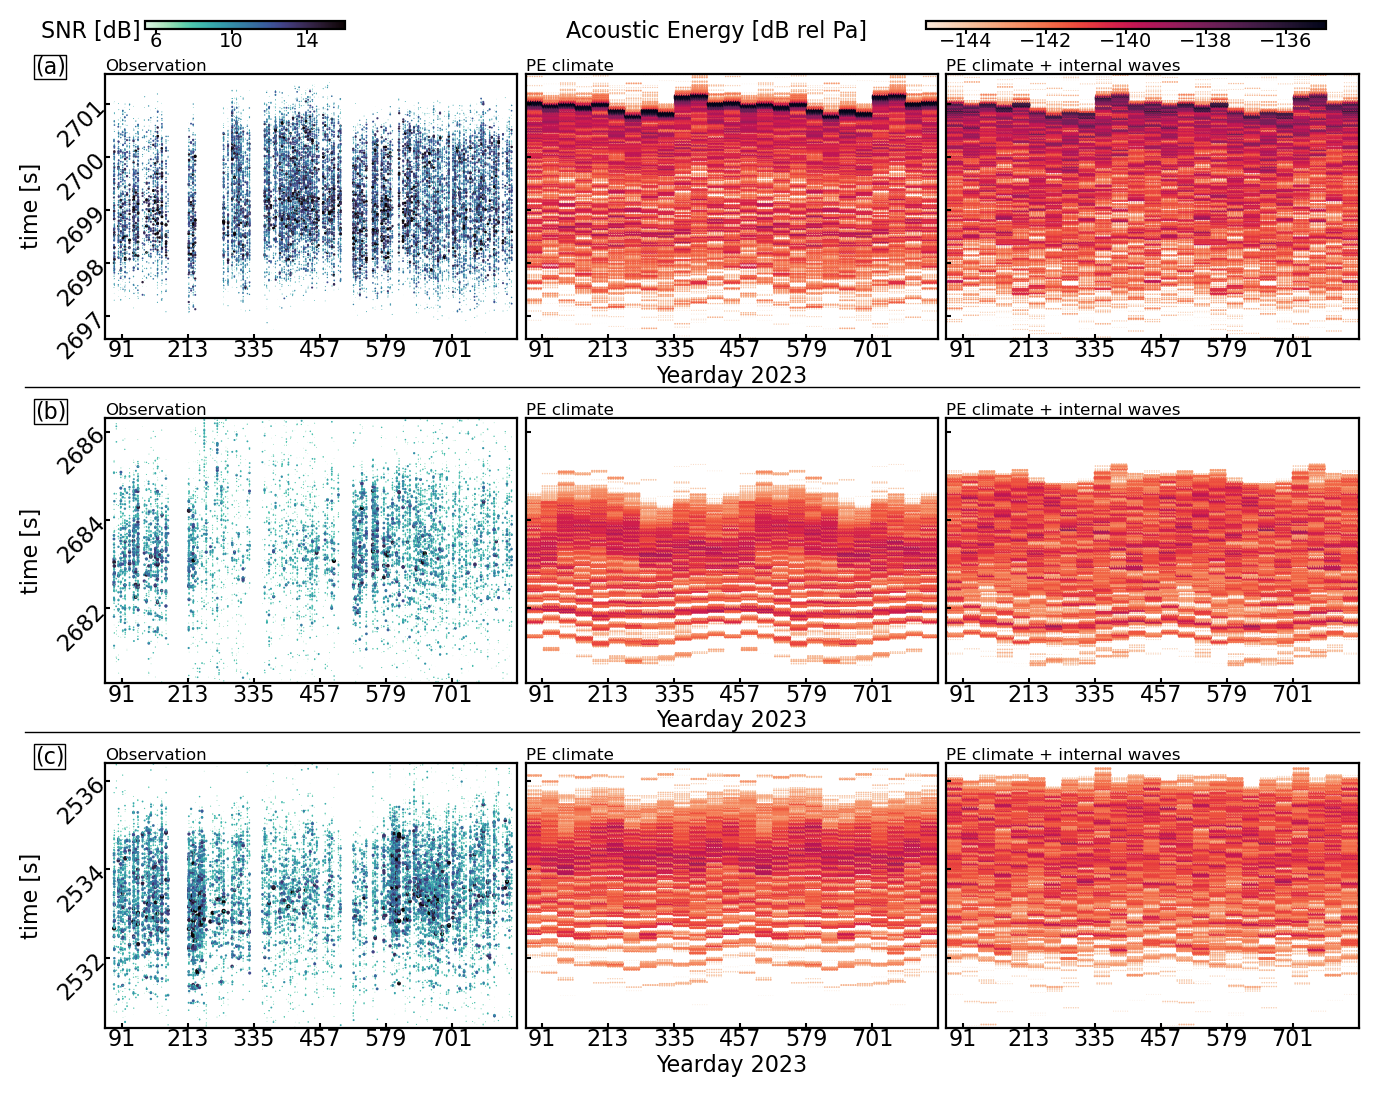

In [11]:
# Full Figure BB
node_plot = ['LJ01C','PC01A','PC03A']

plt.rcParams.update({'font.size':8})

fig = plt.figure(figsize=(6.67,5.25))

gs = gridspec.GridSpec(3,1)

axes_r1 = construct_row(gs, 0)
axes_r2 = construct_row(gs, 1)
axes_r3 = construct_row(gs, 2)

axes = [axes_r1, axes_r2, axes_r3]

# make ticks be inside plot
for axes_r in axes:
    for ax in axes_r:
        ax.tick_params(axis='y', direction='in', length=1.8, width=0.75)
        ax.tick_params(axis='x', direction='in', length=1.8, width=0.75)

# remove tick_labels:
for axes_r in axes:
    for ax in axes_r[1:]:
        ax.set_yticklabels('')

# add ylabel
for axes_r in axes:
    axes_r[0].set_ylabel('time [s]')

# add letter
letters = ['(a)','(b)','(c)','(d)']
for k, axes_r in enumerate(axes):
    axes_r[0].text(
        -0.17,
        1,
        letters[k],
        transform=axes_r[0].transAxes,
        fontsize=8,
        zorder=100,
        bbox=dict(facecolor='white', edgecolor='k', pad=0.3, linewidth=0.5))
    
# add titles to top row
for k in range(3):
    _ = axes[k][0].set_title('Observation', loc='left', fontsize=6, pad=0)
    _ = axes[k][1].set_title('PE climate', loc='left', fontsize=6, pad=0)
    _ = axes[k][2].set_title('PE climate + internal waves', loc='left', fontsize=6, pad=0)


# Plot observations
for k, node in enumerate(['LJ01C','PC01A','PC03A']):
    if node not in node_plot:
        continue
    plt.sca(axes[k][0])
       
    plt.scatter(
        y=peaks[node]['peak_times'] + mls_integer[node]*27.28 + 27.28/2,
        x=peaks[node]['Txs'],
        s=s_rec[node],
        c=peaks[node]['snrs'],
        lw=0,
        cmap='mako_r',
        vmax=vlims_obs[node][0],
        vmin=vlims_obs[node][1],
        rasterized=True
    )
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%J'))
    plt.ylabel('time [s]')
    plt.xlim([pd.Timestamp('2023-03-01'), pd.Timestamp('2025-04-01')])
    plt.xticks([
        pd.Timestamp('2023-04-01'),
        pd.Timestamp('2023-08-01'),
        pd.Timestamp('2023-12-01'),
        pd.Timestamp('2024-04-01'),
        pd.Timestamp('2024-08-01'),
        pd.Timestamp('2024-12-01'),
    ], [91,213,335,457,579,701])
    
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
    axes[k][0].tick_params(axis='y', pad=-2, labelrotation=45)

# Plot simulated climate arrivals
for k, node in enumerate(['LJ01C','PC01A','PC03A']):
    if node not in node_plot:
        continue
    plt.sca(axes[k][1])

    plt.scatter(
        x=months_flatten_b[node],
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node],
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+12,
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+12,
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+24,
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+24,
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    _ = plt.xticks([4,8,12,16,20,24], [91,213,335,457,579,701])
    plt.xlim([3,12+12+4]) # march 1 2023 to april 1 2024
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
    plt.xlabel('Yearday 2023', labelpad=1)

# add Climate + IW
for k, node in enumerate(['LJ01C','PC01A','PC03A']):
    if node not in node_plot:
        continue
        
    plt.sca(axes[k][2])
    plt.scatter(
        x=months_flatten_iw[node],
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node] + 12,
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node],
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node]+12,
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    plt.scatter(
        x=months_flatten_iw[node]+24,
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    plt.scatter(
        x=months_flatten_iw[node] + 24,
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    _ = plt.xticks([4,8,12,16,20,24], [91,213,335,457,579,701])
    plt.xlim([3,12+12+4]) # march 1 2023 to april 1 2024
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks

plt.tight_layout(pad=0)

plt.subplots_adjust(top = 0.95, hspace=0.3)


# add colorbar axes
axc_obs = fig.add_axes((axes[0][0].get_position().xmin + 0.03, 0.992, 0.15, 0.008)) 
cb_obs = matplotlib.colorbar.ColorbarBase(
    axc_obs,
    cmap='mako_r',
    norm=mcolors.Normalize(vmin=vlims_obs['AXCC1'][0], vmax=vlims_obs['AXCC1'][1]),
    orientation='horizontal',
)
plt.sca(axc_obs)
plt.xticks([6,10,14], fontsize=7)
axc_obs.tick_params('x', pad=-1, length=1.8, width=0.75)
axc_obs.text(-0.52,-1,'SNR [dB]', transform=axc_obs.transAxes)

axc_pe = fig.add_axes((axes[0][1].get_position().xmin + 0.3, 0.992, 0.3, 0.008)) 
cb_obs = matplotlib.colorbar.ColorbarBase(
    axc_pe,
    cmap='rocket_r',
    norm=mcolors.Normalize(vmin=vlims_pe['AXCC1'][1], vmax=vlims_pe['AXCC1'][0]),
    orientation='horizontal',
)
plt.sca(axc_pe)
plt.xticks(fontsize=7)
axc_pe.tick_params('x', pad=-1, length=1.8, width=0.75)
axc_pe.text(-0.9,-1,r'Acoustic Energy [dB rel Pa]', transform=axc_pe.transAxes)
print(vlims_pe['AXCC1'])


#fig.add_artist(lines.Line2D([0, 1], [1,1], c='k', linewidth=0.5))
fig.add_artist(lines.Line2D([0, 1], [axes[1][0].get_position().ymax + 0.03, axes[1][0].get_position().ymax + 0.03], c='k', linewidth=0.5))
fig.add_artist(lines.Line2D([0, 1], [axes[2][0].get_position().ymax + 0.03, axes[2][0].get_position().ymax + 0.03], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [axes[3][0].get_position().ymax + 0.02, axes[3][0].get_position().ymax + 0.02], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [0,0], c='k', linewidth=0.5))

# set figure bounds
#ax_bounds = fig.add_axes([0,0,1,1])
#ax_bounds.set_xticks([])
#ax_bounds.set_yticks([])
#ax_bounds.set_facecolor('#00000000')

fig.savefig('figures/bb_dot_plots.pdf', bbox_inches='tight', dpi=600)
# save png for documentation and presentations
#fig.savefig('figures/bb_dot_plots.png', dpi=400)

## Presentation Figures

(-135, -145)


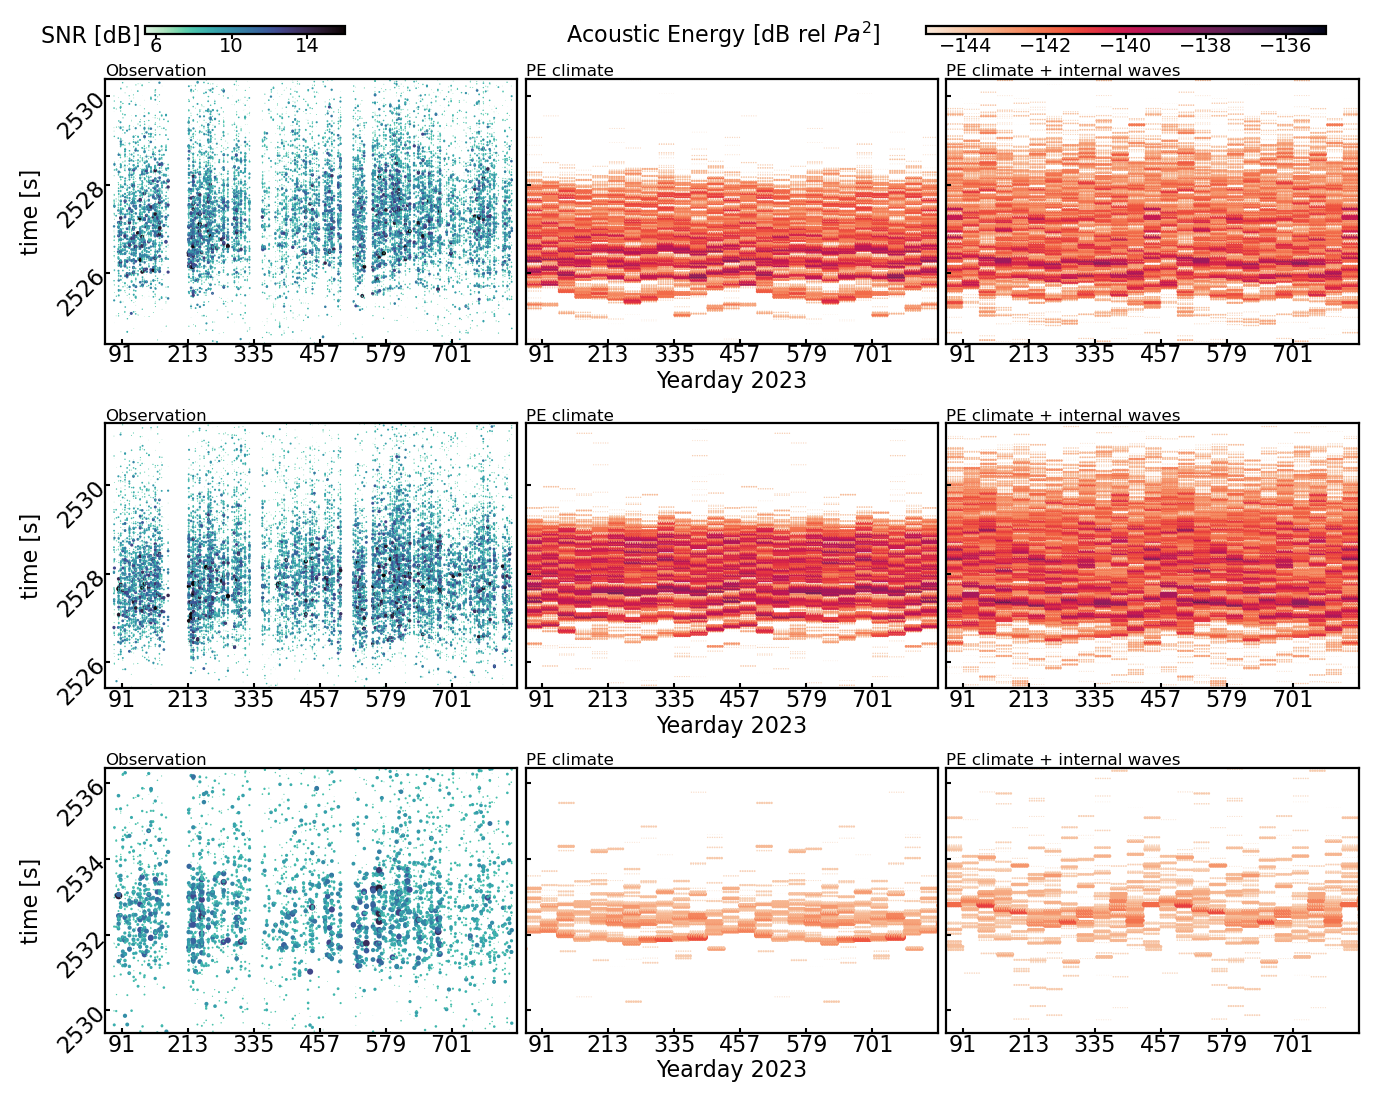

In [15]:
# Full Figure LF
node_plot = ['AXBA1', 'AXCC1','AXEC2']

plt.rcParams.update({'font.size':8})

fig = plt.figure(figsize=(6.67,5.25))

gs = gridspec.GridSpec(3,1)

axes_r1 = construct_row(gs, 0)
axes_r2 = construct_row(gs, 1)
axes_r3 = construct_row(gs, 2)

axes = [axes_r1, axes_r2, axes_r3]

# make ticks be inside plot
for axes_r in axes:
    for ax in axes_r:
        ax.tick_params(axis='y', direction='in', length=1.8, width=0.75)
        ax.tick_params(axis='x', direction='in', length=1.8, width=0.75)

# remove tick_labels:
for axes_r in axes:
    for ax in axes_r[1:]:
        ax.set_yticklabels('')

# add ylabel
for axes_r in axes:
    axes_r[0].set_ylabel('time [s]')

# add titles to top row
for k in range(3):
    _ = axes[k][0].set_title('Observation', loc='left', fontsize=6, pad=0)
    _ = axes[k][1].set_title('PE climate', loc='left', fontsize=6, pad=0)
    _ = axes[k][2].set_title('PE climate + internal waves', loc='left', fontsize=6, pad=0)


# Plot observations
for k, node in enumerate(['AXCC1','AXEC2','AXBA1']):
    if node not in node_plot:
        continue
    plt.sca(axes[k][0])
       
    plt.scatter(
        y=peaks[node]['peak_times'] + mls_integer[node]*27.28 + 27.28/2,
        x=peaks[node]['Txs'],
        s=s_rec[node],
        c=peaks[node]['snrs'],
        lw=0,
        cmap='mako_r',
        vmax=vlims_obs[node][0],
        vmin=vlims_obs[node][1],
        rasterized=True
    )
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%J'))
    plt.ylabel('time [s]')
    plt.xlim([pd.Timestamp('2023-03-01'), pd.Timestamp('2025-04-01')])
    plt.xticks([
        pd.Timestamp('2023-04-01'),
        pd.Timestamp('2023-08-01'),
        pd.Timestamp('2023-12-01'),
        pd.Timestamp('2024-04-01'),
        pd.Timestamp('2024-08-01'),
        pd.Timestamp('2024-12-01'),
    ], [91,213,335,457,579, 701])
    
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
    axes[k][0].tick_params(axis='y', pad=-2, labelrotation=45)

# Plot simulated climate arrivals
for k, node in enumerate(['AXCC1','AXEC2','AXBA1','HYS14']):
    if node not in node_plot:
        continue
    plt.sca(axes[k][1])

    plt.scatter(
        x=months_flatten_b[node],
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node],
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+12,
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+12,
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+24,
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+24,
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    _ = plt.xticks([4,8,12,16,20,24], [91,213,335,457,579,701])
    plt.xlim([3,12+12+4]) # march 1 2023 to april 1 2024
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
    plt.xlabel('Yearday 2023', labelpad=1)

# add Climate + IW
for k, node in enumerate(['AXCC1','AXEC2','AXBA1','HYS14']):
    if node not in node_plot:
        continue
        
    plt.sca(axes[k][2])
    plt.scatter(
        x=months_flatten_iw[node],
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node] + 12,
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node],
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node]+12,
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    plt.scatter(
        x=months_flatten_iw[node]+24,
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    plt.scatter(
        x=months_flatten_iw[node] + 24,
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    _ = plt.xticks([4,8,12,16,20,24], [91,213,335,457,579,701])
    plt.xlim([3,12+12+4]) # march 1 2023 to april 1 2024
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks

plt.tight_layout(pad=0)

plt.subplots_adjust(top = 0.95, hspace=0.3)


# add colorbar axes
axc_obs = fig.add_axes((axes[0][0].get_position().xmin + 0.03, 0.992, 0.15, 0.008)) 
cb_obs = matplotlib.colorbar.ColorbarBase(
    axc_obs,
    cmap='mako_r',
    norm=mcolors.Normalize(vmin=vlims_obs['AXCC1'][0], vmax=vlims_obs['AXCC1'][1]),
    orientation='horizontal',
)
plt.sca(axc_obs)
plt.xticks([6,10,14], fontsize=7)
axc_obs.tick_params('x', pad=-1, length=1.8, width=0.75)
axc_obs.text(-0.52,-1,'SNR [dB]', transform=axc_obs.transAxes)

axc_pe = fig.add_axes((axes[0][1].get_position().xmin + 0.3, 0.992, 0.3, 0.008)) 
cb_obs = matplotlib.colorbar.ColorbarBase(
    axc_pe,
    cmap='rocket_r',
    norm=mcolors.Normalize(vmin=vlims_pe['AXCC1'][1], vmax=vlims_pe['AXCC1'][0]),
    orientation='horizontal',
)
plt.sca(axc_pe)
plt.xticks(fontsize=7)
axc_pe.tick_params('x', pad=-1, length=1.8, width=0.75)
axc_pe.text(-0.9,-1,r'Acoustic Energy [dB rel $Pa^2$]', transform=axc_pe.transAxes)
print(vlims_pe['AXCC1'])


#fig.add_artist(lines.Line2D([0, 1], [1,1], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [axes[1][0].get_position().ymax + 0.03, axes[1][0].get_position().ymax + 0.03], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [axes[2][0].get_position().ymax + 0.03, axes[2][0].get_position().ymax + 0.03], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [axes[3][0].get_position().ymax + 0.02, axes[3][0].get_position().ymax + 0.02], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [0,0], c='k', linewidth=0.5))

# set figure bounds
#ax_bounds = fig.add_axes([0,0,1,1])
#ax_bounds.set_xticks([])
#ax_bounds.set_yticks([])
#ax_bounds.set_facecolor('#00000000')

#fig.savefig('figures/lf_dot_plots.pdf', bbox_inches='tight', dpi=600)
# save png for documentation and presentations
fig.savefig('figures/lf_dot_plots.png', dpi=500)

(-135, -145)


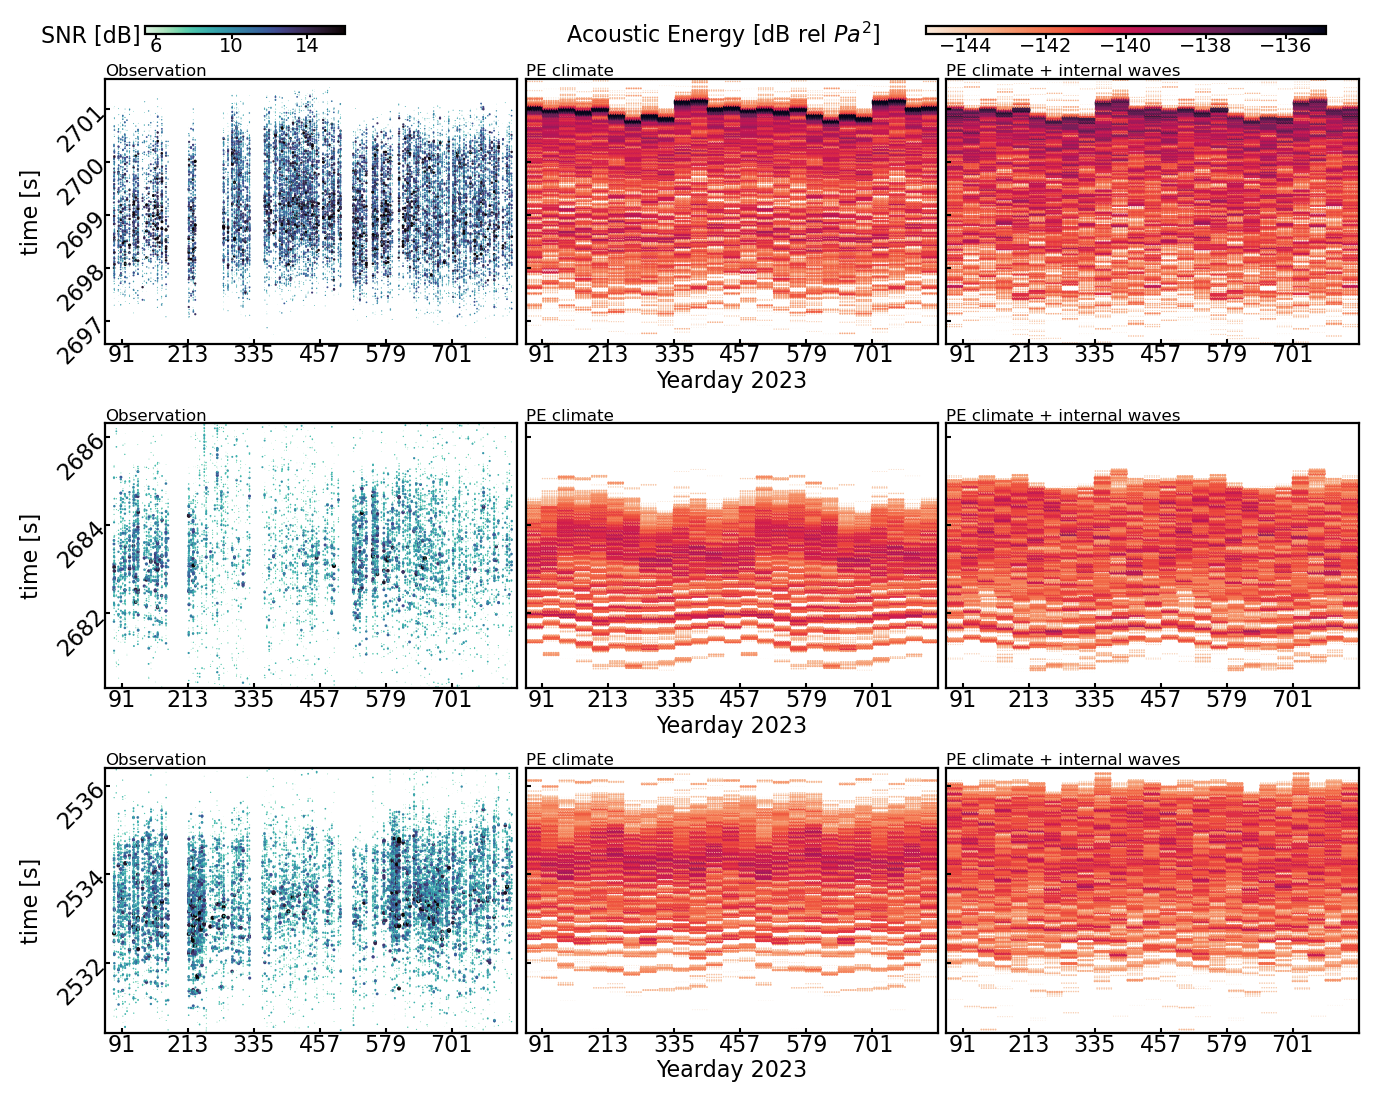

In [16]:
# Full Figure BB
node_plot = ['LJ01C','PC01A','PC03A']

plt.rcParams.update({'font.size':8})

fig = plt.figure(figsize=(6.67,5.25))

gs = gridspec.GridSpec(3,1)

axes_r1 = construct_row(gs, 0)
axes_r2 = construct_row(gs, 1)
axes_r3 = construct_row(gs, 2)

axes = [axes_r1, axes_r2, axes_r3]

# make ticks be inside plot
for axes_r in axes:
    for ax in axes_r:
        ax.tick_params(axis='y', direction='in', length=1.8, width=0.75)
        ax.tick_params(axis='x', direction='in', length=1.8, width=0.75)

# remove tick_labels:
for axes_r in axes:
    for ax in axes_r[1:]:
        ax.set_yticklabels('')

# add ylabel
for axes_r in axes:
    axes_r[0].set_ylabel('time [s]')

# add titles to top row
for k in range(3):
    _ = axes[k][0].set_title('Observation', loc='left', fontsize=6, pad=0)
    _ = axes[k][1].set_title('PE climate', loc='left', fontsize=6, pad=0)
    _ = axes[k][2].set_title('PE climate + internal waves', loc='left', fontsize=6, pad=0)


# Plot observations
for k, node in enumerate(['LJ01C','PC01A','PC03A']):
    if node not in node_plot:
        continue
    plt.sca(axes[k][0])
       
    plt.scatter(
        y=peaks[node]['peak_times'] + mls_integer[node]*27.28 + 27.28/2,
        x=peaks[node]['Txs'],
        s=s_rec[node],
        c=peaks[node]['snrs'],
        lw=0,
        cmap='mako_r',
        vmax=vlims_obs[node][0],
        vmin=vlims_obs[node][1],
        rasterized=True
    )
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%J'))
    plt.ylabel('time [s]')
    plt.xlim([pd.Timestamp('2023-03-01'), pd.Timestamp('2025-04-01')])
    plt.xticks([
        pd.Timestamp('2023-04-01'),
        pd.Timestamp('2023-08-01'),
        pd.Timestamp('2023-12-01'),
        pd.Timestamp('2024-04-01'),
        pd.Timestamp('2024-08-01'),
        pd.Timestamp('2024-12-01'),
    ], [91,213,335,457,579,701])
    
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
    axes[k][0].tick_params(axis='y', pad=-2, labelrotation=45)

# Plot simulated climate arrivals
for k, node in enumerate(['LJ01C','PC01A','PC03A']):
    if node not in node_plot:
        continue
    plt.sca(axes[k][1])

    plt.scatter(
        x=months_flatten_b[node],
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node],
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+12,
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+12,
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+24,
        y=peaks_flatten_b[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_b[node]+24,
        y=peaks_flatten_b[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
        s=s_peb[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    _ = plt.xticks([4,8,12,16,20,24], [91,213,335,457,579,701])
    plt.xlim([3,12+12+4]) # march 1 2023 to april 1 2024
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
    plt.xlabel('Yearday 2023', labelpad=1)

# add Climate + IW
for k, node in enumerate(['LJ01C','PC01A','PC03A']):
    if node not in node_plot:
        continue
        
    plt.sca(axes[k][2])
    plt.scatter(
        x=months_flatten_iw[node],
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node] + 12,
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node],
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    plt.scatter(
        x=months_flatten_iw[node]+12,
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    plt.scatter(
        x=months_flatten_iw[node]+24,
        y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )

    plt.scatter(
        x=months_flatten_iw[node] + 24,
        y=peaks_flatten_iw[node] + fs_integer[node]*10 + delta_t[node],
        lw=0,
        c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
        s=s_peiw[node],
        rasterized=True,
        cmap='rocket_r',
        vmin=vlims_pe_cb[node][1],
        vmax=vlims_pe_cb[node][0],
    )
    _ = plt.xticks([4,8,12,16,20,24], [91,213,335,457,579,701])
    plt.xlim([3,12+12+4]) # march 1 2023 to april 1 2024
    plt.ylim(
        ylims[node][0] + mls_integer[node]*27.28 + 27.28/2,
        ylims[node][1] + mls_integer[node]*27.28 + 27.28/2
    )
    plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks

plt.tight_layout(pad=0)

plt.subplots_adjust(top = 0.95, hspace=0.3)


# add colorbar axes
axc_obs = fig.add_axes((axes[0][0].get_position().xmin + 0.03, 0.992, 0.15, 0.008)) 
cb_obs = matplotlib.colorbar.ColorbarBase(
    axc_obs,
    cmap='mako_r',
    norm=mcolors.Normalize(vmin=vlims_obs['AXCC1'][0], vmax=vlims_obs['AXCC1'][1]),
    orientation='horizontal',
)
plt.sca(axc_obs)
plt.xticks([6,10,14], fontsize=7)
axc_obs.tick_params('x', pad=-1, length=1.8, width=0.75)
axc_obs.text(-0.52,-1,'SNR [dB]', transform=axc_obs.transAxes)

axc_pe = fig.add_axes((axes[0][1].get_position().xmin + 0.3, 0.992, 0.3, 0.008)) 
cb_obs = matplotlib.colorbar.ColorbarBase(
    axc_pe,
    cmap='rocket_r',
    norm=mcolors.Normalize(vmin=vlims_pe['AXCC1'][1], vmax=vlims_pe['AXCC1'][0]),
    orientation='horizontal',
)
plt.sca(axc_pe)
plt.xticks(fontsize=7)
axc_pe.tick_params('x', pad=-1, length=1.8, width=0.75)
axc_pe.text(-0.9,-1,r'Acoustic Energy [dB rel Pa]', transform=axc_pe.transAxes)
print(vlims_pe['AXCC1'])


#fig.add_artist(lines.Line2D([0, 1], [1,1], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [axes[1][0].get_position().ymax + 0.03, axes[1][0].get_position().ymax + 0.03], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [axes[2][0].get_position().ymax + 0.03, axes[2][0].get_position().ymax + 0.03], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [axes[3][0].get_position().ymax + 0.02, axes[3][0].get_position().ymax + 0.02], c='k', linewidth=0.5))
#fig.add_artist(lines.Line2D([0, 1], [0,0], c='k', linewidth=0.5))

# set figure bounds
#ax_bounds = fig.add_axes([0,0,1,1])
#ax_bounds.set_xticks([])
#ax_bounds.set_yticks([])
#ax_bounds.set_facecolor('#00000000')

#fig.savefig('figures/bb_dot_plots.pdf', bbox_inches='tight', dpi=600)
# save png for documentation and presentations
fig.savefig('figures/bb_dot_plots.png', dpi=500)

### single node plots

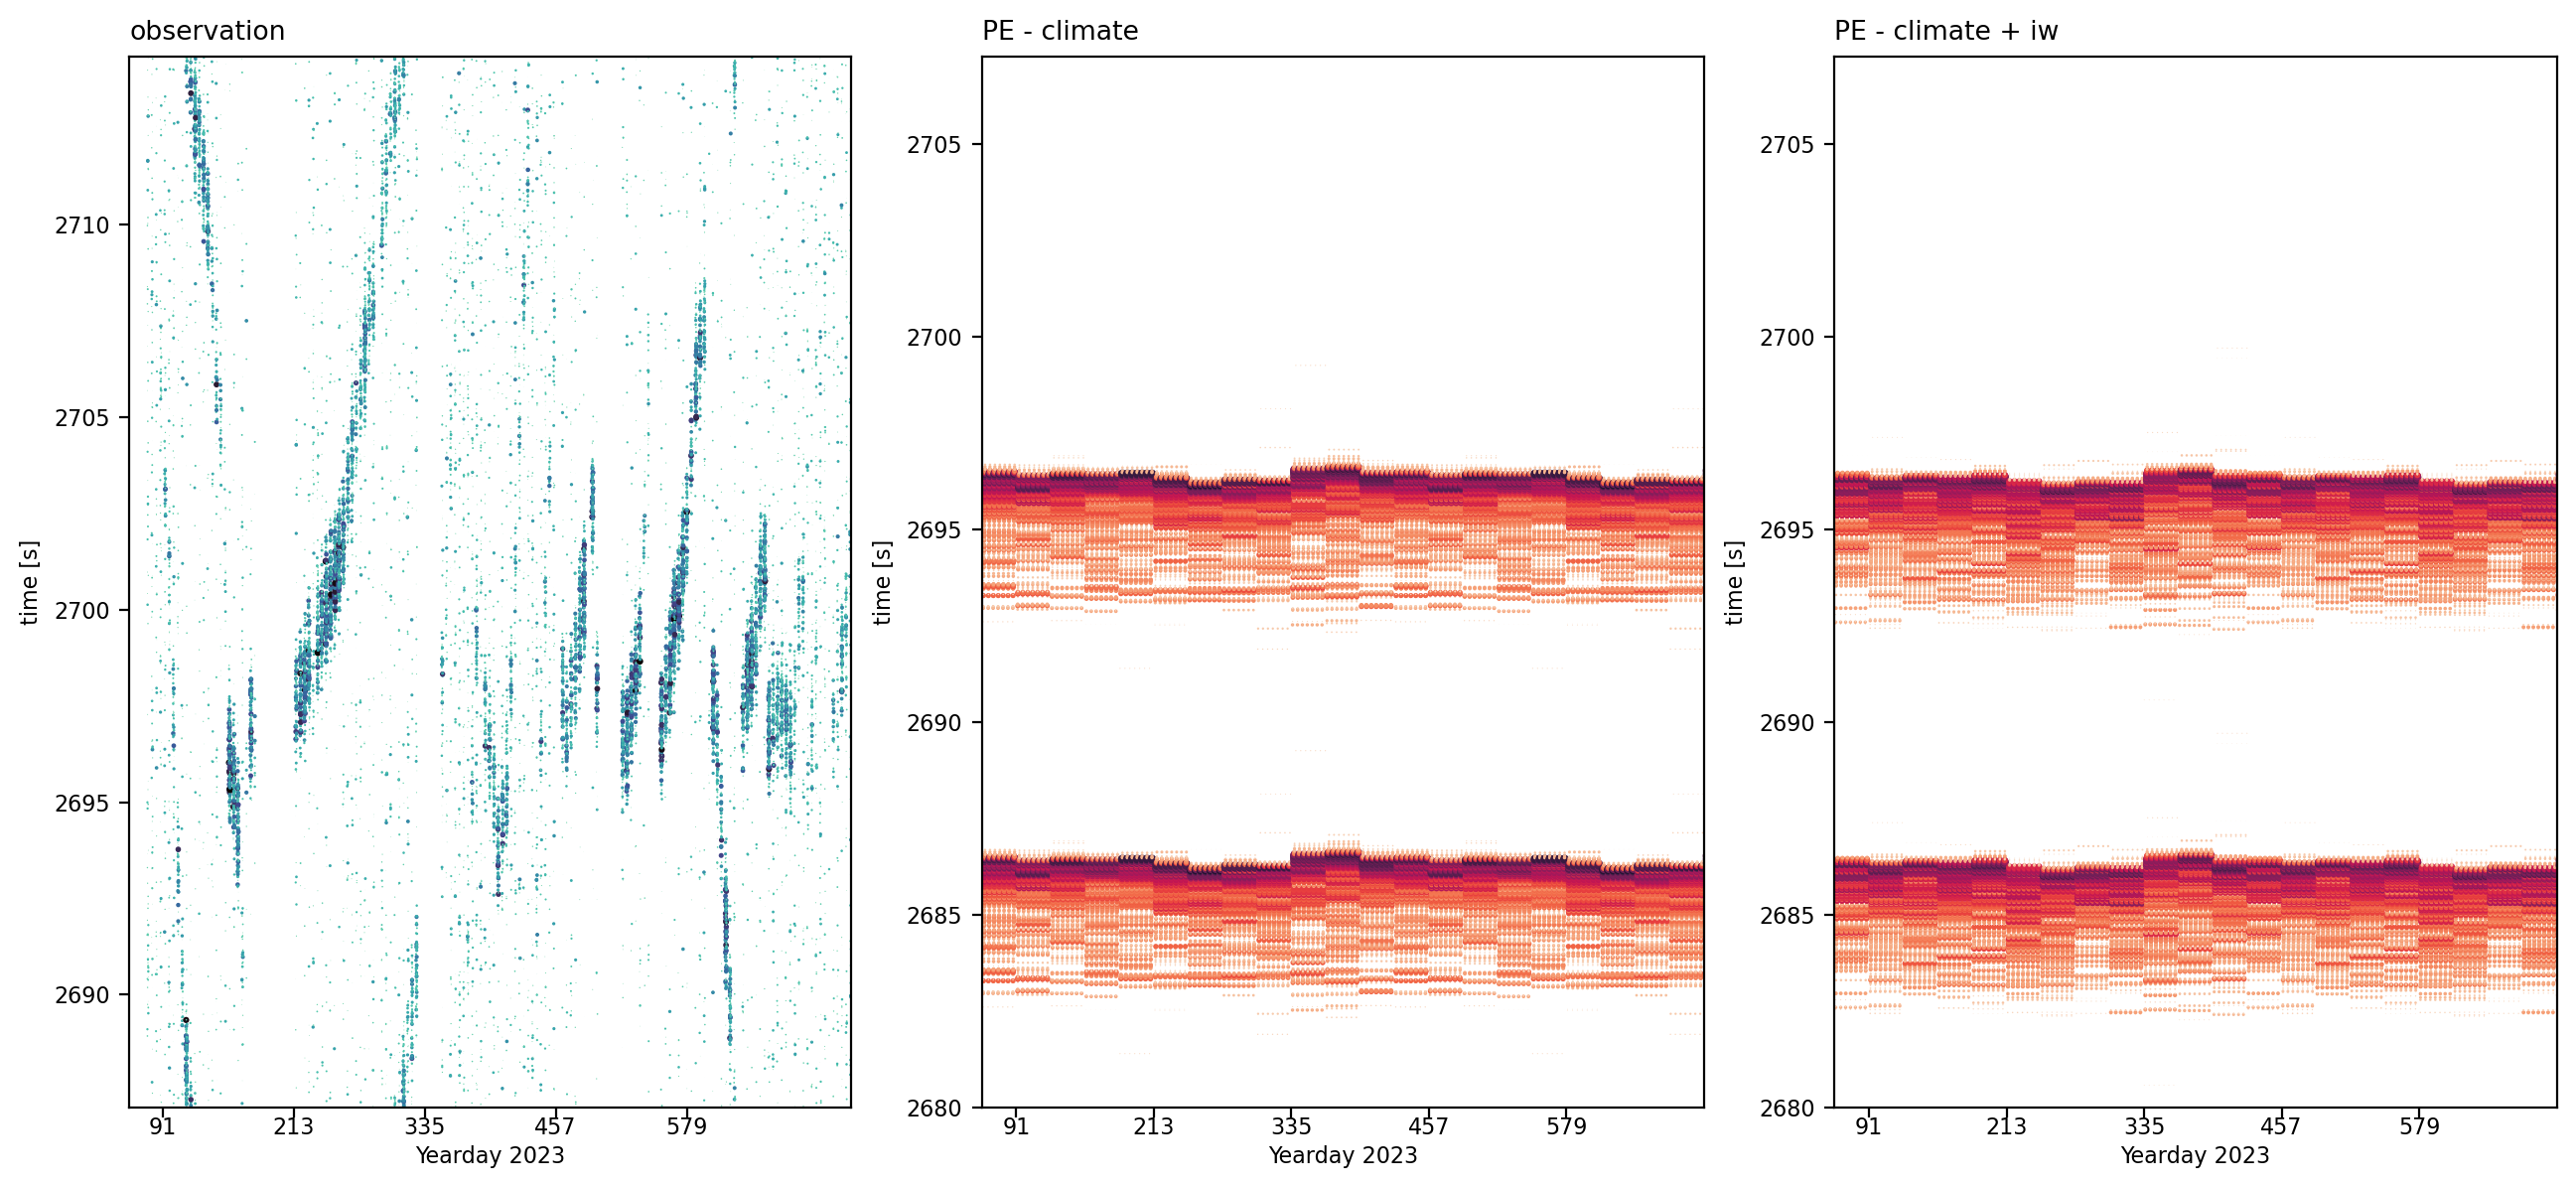

In [49]:
node = 'HYS14'
fig,axes = plt.subplots(1,3,figsize=(13,6))

plt.sca(axes[0])

plt.scatter(
    y=peaks[node]['peak_times'] + 27.28*mls_integer[node] + (27.28/2),
    x=peaks[node]['Txs'],
    s=s_rec[node]*2.5,
    c=peaks[node]['snrs'],
    lw=0,
    cmap='mako_r',
    vmax=vlims_obs[node][0],
    vmin=vlims_obs[node][1],
    rasterized=True
)
plt.ylim(ylims[node][0]+ 27.28*mls_integer[node] + (27.28/2), ylims[node][1]+ 27.28*mls_integer[node] + (27.28/2))
plt.ylabel('time [s]')
plt.xlim([pd.Timestamp('2023-03-01'), pd.Timestamp('2025-01-01')])
plt.xticks([
    pd.Timestamp('2023-04-01'),
    pd.Timestamp('2023-08-01'),
    pd.Timestamp('2023-12-01'),
    pd.Timestamp('2024-04-01'),
    pd.Timestamp('2024-08-01')
], [91,213,335,457,579])

plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
plt.xlabel('Yearday 2023', labelpad=2)
plt.title('observation',loc='left')

plt.sca(axes[1])

plt.scatter(
    x=months_flatten_b[node],
    y=peaks_flatten_b[node] + fs_integer[node]*10,
    lw=0,
    c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
    s=s_peb[node]*2.5,
    rasterized=True,
    cmap='rocket_r',
    vmin=vlims_pe_cb[node][1],
    vmax=vlims_pe_cb[node][0],
)
plt.scatter(
    x=months_flatten_b[node],
    y=peaks_flatten_b[node]+ (fs_integer[node]+1)*10,
    lw=0,
    c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
    s=s_peb[node]*2.5,
    rasterized=True,
    cmap='rocket_r',
    vmin=vlims_pe_cb[node][1],
    vmax=vlims_pe_cb[node][0],
)
plt.scatter(
    x=months_flatten_b[node]+12,
    y=peaks_flatten_b[node] + fs_integer[node]*10,
    lw=0,
    c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
    s=s_peb[node]*2.5,
    rasterized=True,
    cmap='rocket_r',
    vmin=vlims_pe_cb[node][1],
    vmax=vlims_pe_cb[node][0],
)
plt.scatter(
    x=months_flatten_b[node]+12,
    y=peaks_flatten_b[node]+ (fs_integer[node]+1)*10,
    lw=0,
    c=20*np.log10(np.abs(peak_heights_flatten_b[node])),
    s=s_peb[node]*2.5,
    rasterized=True,
    cmap='rocket_r',
    vmin=vlims_pe_cb[node][1],
    vmax=vlims_pe_cb[node][0],
)

_ = plt.xticks([4,8,12,16,20], [91,213,335,457,579])
plt.xlim([3,12+12])
plt.ylim(ylims[node][0]+ 10*fs_integer[node], ylims[node][1]+ 10*fs_integer[node])
plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks
plt.xlabel('Yearday 2023', labelpad=2)
plt.ylabel('time [s]')
plt.title('PE - climate',loc='left')

# add Climate + IW
plt.sca(axes[2])

plt.scatter(
    x=months_flatten_iw[node],
    y=peaks_flatten_iw[node] + fs_integer[node]*10,
    lw=0,
    c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
    s=s_peiw[node]*2.5,
    rasterized=True,
    cmap='rocket_r',
    vmin=vlims_pe_cb[node][1],
    vmax=vlims_pe_cb[node][0],
)
plt.scatter(
    x=months_flatten_iw[node] + 12,
    y=peaks_flatten_iw[node] + fs_integer[node]*10,
    lw=0,
    c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
    s=s_peiw[node]*2.5,
    rasterized=True,
    cmap='rocket_r',
    vmin=vlims_pe_cb[node][1],
    vmax=vlims_pe_cb[node][0],
)
plt.scatter(
    x=months_flatten_iw[node],
    y=peaks_flatten_iw[node] + (fs_integer[node]+1)*10,
    lw=0,
    c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
    s=s_peiw[node]*2.5,
    rasterized=True,
    cmap='rocket_r',
    vmin=vlims_pe_cb[node][1],
    vmax=vlims_pe_cb[node][0],
)
plt.scatter(
    x=months_flatten_iw[node]+12,
    y=peaks_flatten_iw[node]+ (fs_integer[node]+1)*10,
    lw=0,
    c=20*np.log10(np.abs(peak_heights_flatten_iw[node])),
    s=s_peiw[node]*2.5,
    rasterized=True,
    cmap='rocket_r',
    vmin=vlims_pe_cb[node][1],
    vmax=vlims_pe_cb[node][0],
)
_ = plt.xticks([4,8,12,16,20], [91,213,335,457,579])
plt.xlim([3,12+12])
plt.ylim(ylims[node][0]+ 10*fs_integer[node], ylims[node][1]+ 10*fs_integer[node])
plt.xlabel('Yearday 2023', labelpad=2)
plt.ylabel('time [s]')

plt.title('PE - climate + iw',loc='left')
plt.gca().tick_params(axis='x', which='major', pad=0)  # Major ticks


plt.tight_layout()

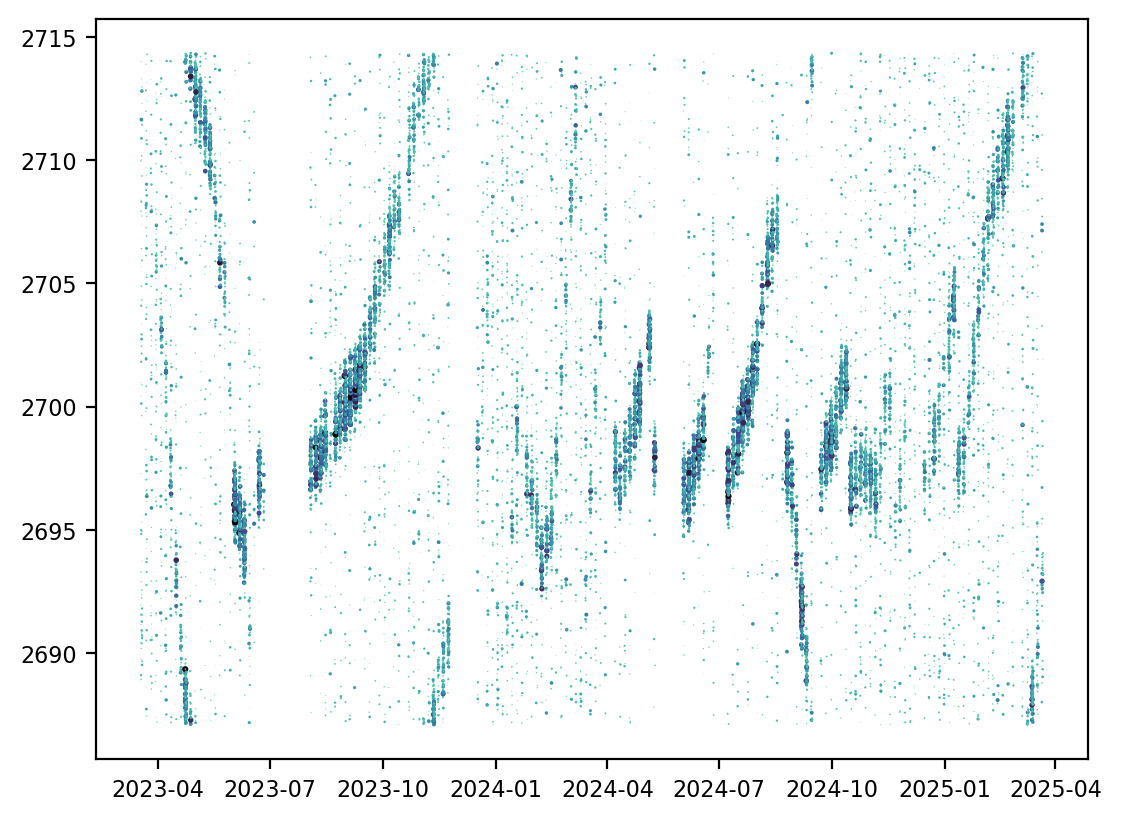

In [48]:
plt.scatter(
    y=peaks[node]['peak_times'] + 27.28*mls_integer[node] + (27.28/2),
    x=peaks[node]['Txs'],
    s=s_rec[node]*2.5,
    c=peaks[node]['snrs'],
    lw=0,
    cmap='mako_r',
    vmax=vlims_obs[node][0],
    vmin=vlims_obs[node][1],
    rasterized=True
)
#plt.xlim([pd.Timestamp('2024-10-15'), pd.Timestamp('2024-11-15')])

(5.0, 15.0)

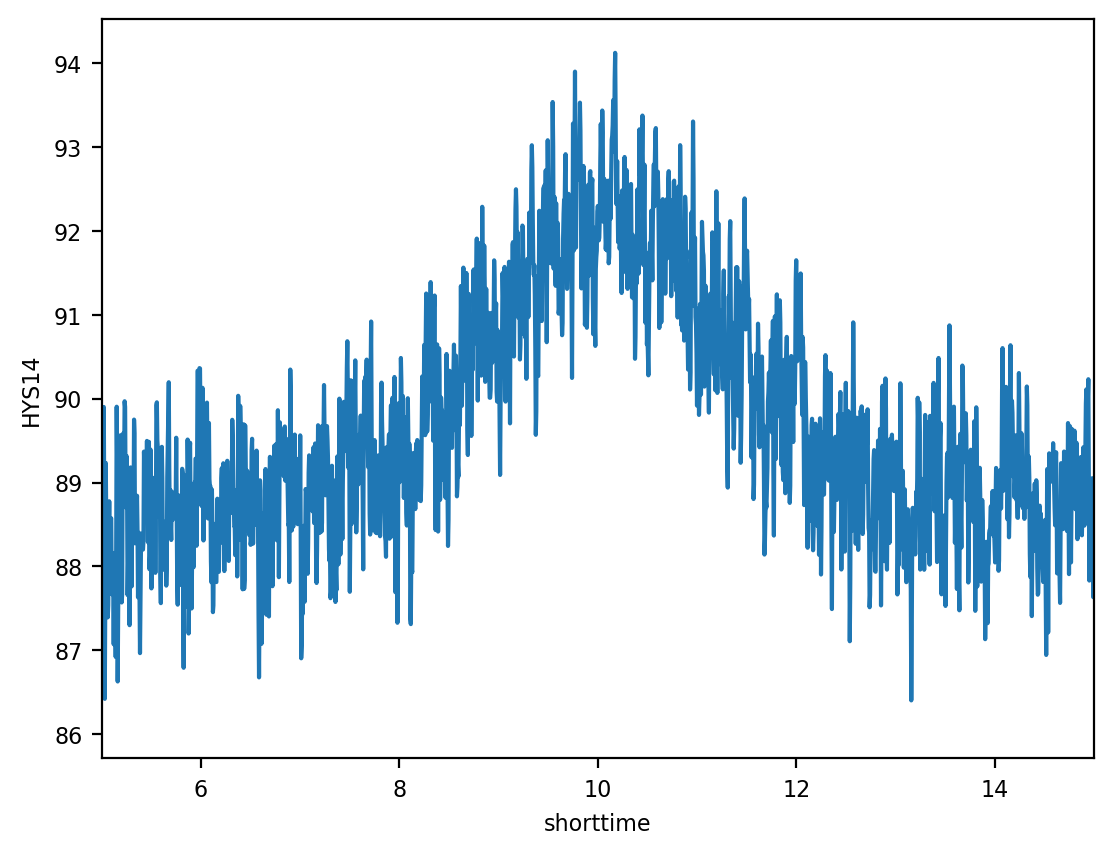

In [47]:
(20*np.log10(lf_stack['HYS14'].sel({'transmission':slice(pd.Timestamp('2024-10-15'), pd.Timestamp('2024-11-13'))}).sum('transmission'))).plot()
plt.xlim([5,15])